NNConv層
$$
\textbf X_i^{(t)}=\textbf W \textbf X_i^{(t-1)}+\sum_{j\in N(i)} \textbf X_j^{(t-1)}\dot h_{\theta}\left(e_{i,j}\right)
$$
hは重みの集合θによってパラメータ化されたNNである。
Wはノードラベルの重み行列である。


In [2]:
import torch
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool
#NNConv層：エッジ特徴量を使えるグラフ畳み込み
#code: https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/conv/nn_conv.html#NNConv
#Saved at ./nnconv.py
import torch.nn.functional as F
import torch.nn as nn
import numpy as np

In [3]:
# QM9のダウンロード＆読み込み
dataset = QM9(root="./QM9/")
len(dataset)

130831

QM9の属性
x:ノードの特徴量
y:ラベル
z:原子番号
edge_attr:エッジ特徴量
edge_index:エッジリスト
pos:3Dグリッドでの各原子の位置



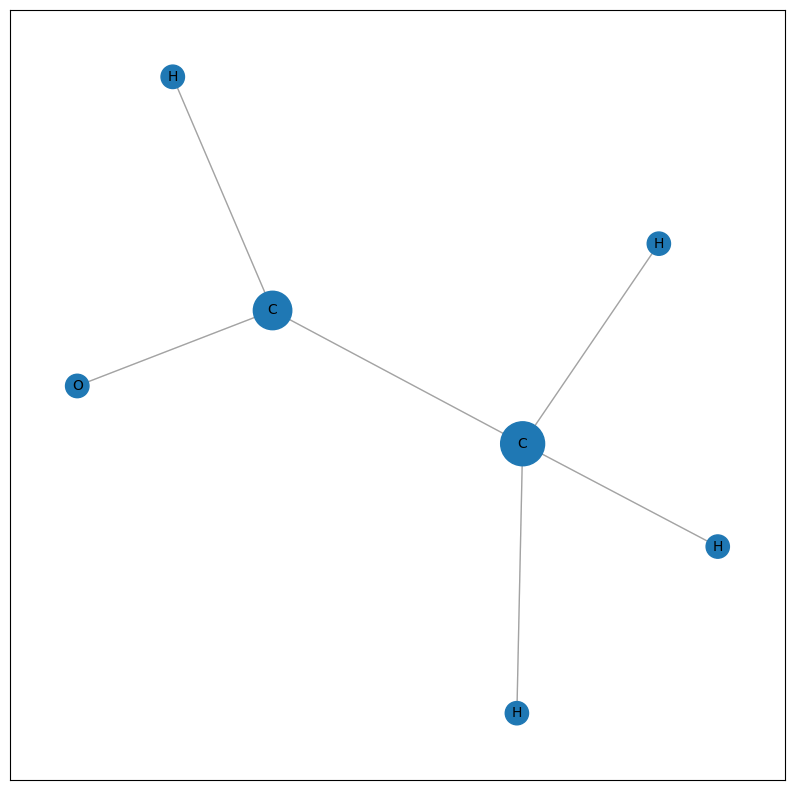

In [19]:
# グラフ構造の可視化
import networkx
from matplotlib import pyplot as plt
import numpy as np
from torch_geometric.utils import to_networkx

data = dataset[10]
nxg = to_networkx(data)

#原子番号追加
elements = {
    1:"H",
    2:"He",
    3:"Li",
    4:"Be",
    5:"B",
    6:"C",
    7:"N",
    8:"O",
    9:"F"
}
elem_labels = {}
for i in range(data.num_nodes):
    elem = elements[int(data.z[i])]
    elem_labels[i] = elem

pagerank = networkx.pagerank(nxg) #pagerankはノードの中心性(重要性の指標)
pagerank_max = np.array(list(pagerank.values())).max()

#可視化する時のノード位置
draw_position = networkx.spring_layout(nxg,seed=0)

plt.figure(figsize=(10,10))

networkx.draw_networkx_nodes(nxg,
                            draw_position,
                            node_size=[v / pagerank_max * 1000 for v in pagerank.values()]
                            )

networkx.draw_networkx_edges(nxg, draw_position, arrowstyle='-', alpha=0.2)
networkx.draw_networkx_labels(nxg, draw_position, elem_labels, font_size=10)
plt.show()

In [8]:
#NNConvを使用するGNNの実装
class GNNmodel(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super().__init__()
        conv1_nn = nn.Sequential(nn.Linear(num_edge_features, 32),
                                nn.ReLU(),
                                nn.Linear(32, num_node_features*32)
                                )
        conv2_nn = nn.Sequential(nn.Linear(num_edge_features, 32),
                                nn.ReLU(),
                                nn.Linear(32, 32*16)
                                ) 
        self.conv1 = NNConv(dataset.num_node_features, 32, conv1_nn)
        self.conv2 = NNConv(32,16,conv2_nn)
        self.func_1 = nn.Linear(16,32)
        self.out = nn.Linear(32,1)
        
    def forward(self, data):
        batch, x, edge_index, edge_attr = data.batch, data.x, data.edge_index, data.edge_attr
        #畳み込み層
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        
        x = global_add_pool(x, batch)
        x = F.relu(self.func_1(x))
        output = self.out(x)
        return output

In [4]:
# GCN層
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)
        self.out = nn.Linear(num_classes, 1)

    def forward(self, data):
        batch, x, edge_index, edge_attr = data.batch, data.x, data.edge_index, data.edge_attr

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.log_softmax(self.conv2(x, edge_index),dim=1)
        output = self.out(x)
        return output

In [6]:
from torch.utils.data import random_split

#データの分割(total: 130831)
train_set, valid_set, test_set = random_split(dataset, [110000, 10831, 10000])

#Dataloaderの生成
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

# GNNの初期化
network = GCN(dataset.num_node_features, dataset.num_edge_features, dataset.num_classes)

# optimizerの初期化
target_idx = 1 # 分極率(Isotropic polarizability)
optimizer = torch.optim.Adam(network.parameters(), lr=0.01)
epochs = 3

In [10]:
# 訓練

# 学習したいラベルのインデックス位置

network.to("cpu")

for total_epochs in range(epochs):
    epoch_loss = 0
    total_graphs = 0
    network.train()
    for batch in train_loader:
        batch.to("cpu")
        optimizer.zero_grad()
        output = network(batch)
        loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    
    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    network.eval()
    for batch in valid_loader:
        batch.to("cpu")
        output = network(batch)
        print(output)
        loss = torch.sqrt(F.mse_loss(output,batch.y[:, target_idx].unsqueeze(1))) #平方根で比較
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    
    val_avg_loss = val_loss / total_graphs
    print(f"Epochs: {total_epochs} | epoch avg. loss: {train_avg_loss:.2f} | validation avg. loss: {val_avg_loss:.2f}")
    

/tmp/ipykernel_748183/2004113662.py:15: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([576, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1))


RuntimeError: The size of tensor a (576) must match the size of tensor b (32) at non-singleton dimension 0

In [10]:
import pandas as pd
df = pd.read_csv("../QM9_target.csv", encoding="shift-jis")
df

,Target,Property,description,Unit
0,0,μ,Dipole moment,D
1,1,α,Isotropic polarizability,a0^3
2,2,E_HOMO,Highest occupied molecular orbital energy,eV
3,3,E_LUMO,Lowest unoccupied molecular orbital energy,eV
4,4,ΔE,Gap between?HOMO?and?LUMO,eV
5,5,<R^2>,Electronic spatial extent,ao^2
6,6,ZPVE,Zero point vibrational energy,eV
7,7,U_0,Internal energy at 0K,eV
8,8,U_0,Internal energy at 298.15K,eV
9,9,H,Enthalpy at 298.15K,eV


In [15]:
network.eval()
predictions = []
real = []
for batch in test_loader:
    output = network(batch.to("cpu"))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:,target_idx].detach().cpu().numpy())
real = np.concatenate(real)
predictions = np.concatenate(predictions)

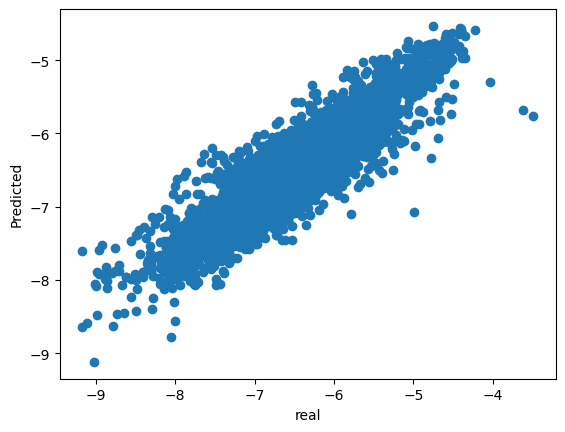

In [18]:
plt.scatter(real, predictions)
plt.ylabel('Predicted')
plt.xlabel('real')
plt.show()